# <span style="color:green"> Bi-LSTM RNN ON 8*8 MNIST DATASET TO PREDICT TEN CLASS


### <span style="color:blue">Its a dynamic sequence and batch bi directional LSTM . This is created with tensorflow scan and map higher ops!!!! 
###  <span style="color:blue">This is a base bi directional LSTM which can be used to create Neural Stack Machine, Neural Turing Machine and  RNN-EM and so on!

# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.cross_validation import train_test_split
import pylab as pl
from IPython import display
import sys
%matplotlib inline

# Bi-LSTM class and functions

In [2]:
class Bi_LSTM_cell(object):

    """
    Bi directional LSTM cell object which takes 3 arguments for initialization.
    input_size = Input Vector size
    hidden_layer_size = Hidden layer size
    target_size = Output vector size

    """

    def __init__(self, input_size, hidden_layer_size, target_size):

        # Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size

        # Weights and Bias for input and hidden tensor for forward pass
        self.Wi = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Ui = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size]))

        
        self.Wf = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uf = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wog = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uog = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wc = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uc = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bc = tf.Variable(tf.zeros([self.hidden_layer_size]))        

        
        
        # Weights and Bias for input and hidden tensor for backward pass
        self.Wi1 = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Ui1 = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bi1 = tf.Variable(tf.zeros([self.hidden_layer_size]))

        
        self.Wf1 = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uf1 = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bf1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wog1 = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uog1 = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bog1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        self.Wc1 = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uc1 = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bc1 = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        
        # Weights for output layers
        self.Wo = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size*2, self.target_size],mean=0,stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.target_size],mean=0,stddev=.01))

        # Placeholder for input vector with shape[batch, seq, embeddings]
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')
        
        #Reversing the inputs by sequence for backward pass of the LSTM
        self._inputs_rev= tf.reverse(self._inputs,[False,True,False])
        
        # Processing inputs to work with scan function
        self.processed_input = process_batch_input_for_RNN(self._inputs)
        
        #For bacward pass of the LSTM
        self.processed_input_rev = process_batch_input_for_RNN(self._inputs_rev)
        
        '''
        Initial hidden state's shape is [1,self.hidden_layer_size]
        In First time stamp, we are doing dot product with weights to
        get the shape of [batch_size, self.hidden_layer_size].
        For this dot product tensorflow use broadcasting. But during
        Back propagation a low level error occurs.
        So to solve the problem it was needed to initialize initial
        hiddden state of size [batch_size, self.hidden_layer_size].
        So here is a little hack !!!! Getting the same shaped
        initial hidden state of zeros.
        '''

        self.initial_hidden = self._inputs[:, 0, :]
        self.initial_hidden= tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size]))
        
        
        self.initial_hidden=tf.pack([self.initial_hidden,self.initial_hidden])
        
    # Function for Forward LSTM cell. 
    def Lstm_f(self, previous_hidden_memory_tuple, x):
        """
        This function takes previous hidden state and memory tuple with input and
        outputs current hidden state.
        """
        
        previous_hidden_state,c_prev=tf.unpack(previous_hidden_memory_tuple)
        
        #Input Gate
        i= tf.sigmoid(
            tf.matmul(x,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi 
        )
        
        #Forget Gate
        f= tf.sigmoid(
            tf.matmul(x,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf 
        )
        
        #Output Gate
        o= tf.sigmoid(
            tf.matmul(x,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog
        )
        
        #New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(x,self.Wc)+tf.matmul(previous_hidden_state,self.Uc) + self.bc 
        ) 
        
        #Final Memory cell
        c= f*c_prev + i*c_
        
        #Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)


        return tf.pack([current_hidden_state,c])

    # Function for Forward LSTM cell. 
    def Lstm_b(self, previous_hidden_memory_tuple, x):
        """
        This function takes previous hidden state and memory tuple with input and
        outputs current hidden state.
        """
        
        previous_hidden_state,c_prev=tf.unpack(previous_hidden_memory_tuple)
        
        #Input Gate
        i= tf.sigmoid(
            tf.matmul(x,self.Wi1)+tf.matmul(previous_hidden_state,self.Ui1) + self.bi1
        )
        
        #Forget Gate
        f= tf.sigmoid(
            tf.matmul(x,self.Wf1)+tf.matmul(previous_hidden_state,self.Uf1) + self.bf1 
        )
        
        #Output Gate
        o= tf.sigmoid(
            tf.matmul(x,self.Wog1)+tf.matmul(previous_hidden_state,self.Uog1) + self.bog1
        )
        
        #New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(x,self.Wc1)+tf.matmul(previous_hidden_state,self.Uc1) + self.bc1 
        ) 
        
        #Final Memory cell
        c= f*c_prev + i*c_
        
        #Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)


        return tf.pack([current_hidden_state,c])    
    
    

    #Function to get the hidden and memory cells after forward pass
    def get_states_f(self):
        """
        Iterates through time/ sequence to get all hidden state
        """

        # Getting all hidden state throuh time
        all_hidden_memory_states = tf.scan(self.Lstm_f,
                                    self.processed_input,
                                    initializer=self.initial_hidden,
                                    name='states')
        
        all_hidden_states=all_hidden_memory_states[:,0,:,:]
        all_memory_states=all_hidden_memory_states[:,1,:,:]

        
        return all_hidden_states,all_memory_states

    
    #Function to get the hidden and memory cells after backward pass
    def get_states_b(self):
        """
        Iterates through time/ sequence to get all hidden state
        """
        
        all_hidden_states, all_memory_states = self.get_states_f()
        
        #Reversing the hidden and memory state to get the final hidden and memory state
        last_hidden_states = tf.reverse(all_hidden_states,[True,False,False])[0,:,:]
        last_memory_states = tf.reverse(all_memory_states,[True,False,False])[0,:,:]
        
        #For backward pass using the last hidden and memory of the forward pass
        initial_hidden=tf.pack([last_hidden_states,last_memory_states])
        
        # Getting all hidden state throuh time
        all_hidden_memory_states = tf.scan(self.Lstm_b,
                                    self.processed_input_rev,
                                    initializer=initial_hidden,
                                    name='states')
        
        #Now reversing the states to keep those in original order
        all_hidden_states=tf.reverse(all_hidden_memory_states[:,0,:,:],[True,False,False])
        all_memory_states=tf.reverse(all_hidden_memory_states[:,1,:,:],[True,False,False])

        
        return all_hidden_states,all_memory_states    
    
    
    #Function to concat the hiddenstates for backward and forward pass
    def get_concat_hidden(self):
        
        #Getting hidden and memory for the forward pass
        all_hidden_states_f, all_memory_states_f = self.get_states_f()
        
        #Getting hidden and memory for the backward pass
        all_hidden_states_b, all_memory_states_b = self.get_states_b()
        
        #Concating the hidden states of forward and backward pass
        concat_hidden=tf.concat(2,[all_hidden_states_f,all_hidden_states_b])
        
        return concat_hidden


    # Function to get output from a hidden layer
    def get_output(self, hidden_state):
        """
        This function takes hidden state and returns output
        """
        output = tf.nn.sigmoid(tf.matmul(hidden_state, self.Wo) + self.bo)

        return output

    # Function for getting all output layers
    def get_outputs(self):
        """
        Iterating through hidden states to get outputs for all timestamp
        """
        all_hidden_states = self.get_concat_hidden()

        all_outputs = tf.map_fn(self.get_output, all_hidden_states)

        return all_outputs


# Function to convert batch input data to use scan ops of tensorflow.
def process_batch_input_for_RNN(batch_input):
    """
    Process tensor of size [5,3,2] to [3,5,2]
    """
    batch_input_ = tf.transpose(batch_input, perm=[2, 0, 1])
    X = tf.transpose(batch_input_)

    return X


# Placeholder and initializers


In [3]:
hidden_layer_size = 30
input_size = 8
target_size = 10

In [4]:
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')

# Models

In [5]:
#Initializing rnn object
rnn=Bi_LSTM_cell( input_size, hidden_layer_size, target_size)

In [6]:
#Getting all outputs from rnn
outputs = rnn.get_outputs()

In [7]:
#Getting first output through indexing
last_output = outputs[0,:,:]

In [8]:
#As rnn model output the final layer through Relu activation softmax is used for final output.
output=tf.nn.softmax(last_output)

In [9]:
#Computing the Cross Entropy loss 
cross_entropy = -tf.reduce_sum(y * tf.log(output))

In [10]:
# Trainning with Adadelta Optimizer
train_step = tf.train.AdadeltaOptimizer().minimize(cross_entropy)

In [11]:
#Calculatio of correct prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

# Dataset Preparation

In [12]:
#Function to get on hot
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot
    

In [13]:
#Using Sklearn MNIST dataset.
digits = datasets.load_digits()
X=digits.images
Y_=digits.target

Y=map(get_on_hot,Y_)

In [14]:
#Getting Train and test Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=42)

#Cuttting for simple iteration
X_train=X_train[:1400]
y_train=y_train[:1400]

In [15]:
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

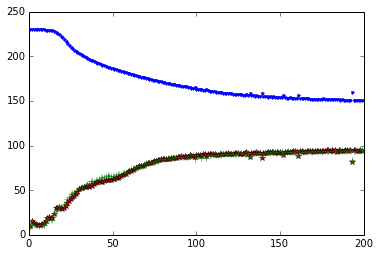

Iteration: 199 Loss: 150.816 Train Accuracy: 94.4 Test Accuracy: 94.697


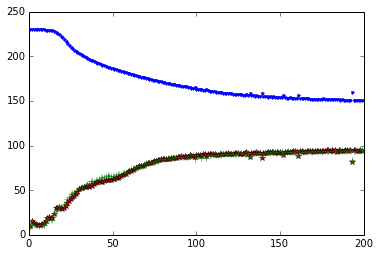

In [16]:
#Iterations to do trainning
for epoch in range(200):
    
    start=0
    end=100
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        start=end
        end=start+100
        sess.run(train_step,feed_dict={rnn._inputs:X, y:Y})
    
    Loss=str(sess.run(cross_entropy,feed_dict={rnn._inputs:X, y:Y}))
    Train_accuracy=str(sess.run(accuracy,feed_dict={rnn._inputs:X_train[:500], y:y_train[:500]}))
    Test_accuracy=str(sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test}))
    

    pl.plot([epoch],Loss,'b.',)
    pl.plot([epoch],Train_accuracy,'r*',)
    pl.plot([epoch],Test_accuracy,'g+')
    display.clear_output(wait=True)
    display.display(pl.gcf())   
    
    sys.stdout.flush()
    print("\rIteration: %s Loss: %s Train Accuracy: %s Test Accuracy: %s"%(epoch,Loss,Train_accuracy,Test_accuracy)),
    sys.stdout.flush()

